In [1]:
# Import libraries

# Data manipulation and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Machine learning model
from sklearn.linear_model import LinearRegression, Ridge

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix

In [2]:
# CLEANING DATA 

# Load the dataset from the GitHub repository
url = "https://github.com/kristenauriemma/595Project/raw/main/USvideos.csv"
df = pd.read_csv(url)
print(df.head())

# Convert 'trending_date' to datetime format (DD.MM.YY)
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%d.%m.%y', errors='coerce')

# Drop rows with invalid 'trending_date' but keep those with valid views
df = df.dropna(subset=['trending_date'])
# Drop rows with missing 'video_id'
df = df.dropna(subset=['video_id'])
# Drop duplicates
df = df.drop_duplicates()

# Ensure 'views' is numeric and remove rows where 'views' is NaN
df['views'] = pd.to_numeric(df['views'], errors='coerce')
df = df.dropna(subset=['views'])  # Drop rows where 'views' is NaN

# Handle missing values in other columns
numeric_columns = df.select_dtypes(include=['number']).columns

# Fill missing numeric columns with the mean
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Convert 'category_id' to category type (if you plan to use this in models)
df['category_id'] = df['category_id'].astype('category')

# Replace 0 with the median for likes, dislikes, and comment_count
median_likes = df['likes'].median() 
df['likes'] = df['likes'].replace(0, median_likes) 

median_dislikes = df['dislikes'].median() 
df['dislikes'] = df['dislikes'].replace(0, median_dislikes) 

median_comment = df['comment_count'].median() 
df['comment_count'] = df['comment_count'].replace(0, median_comment)

# Convert 'publish_time' to datetime and extract year, month, and day
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
df['publish_year'] = df['publish_time'].dt.year
df['publish_month'] = df['publish_time'].dt.month
df['publish_day'] = df['publish_time'].dt.day

# Extract year, month, and day from 'trending_date'
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m', errors='coerce')
df['trending_year'] = df['trending_date'].dt.year
df['trending_month'] = df['trending_date'].dt.month
df['trending_day'] = df['trending_date'].dt.day

# Reset index
df = df.reset_index(drop=True)

      video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id              publish_time  \
0           22  2017-11-13T17:13:01.000Z   
1           24  2017-11-13T07:30:00.000Z   
2           23  2017-11-12T19:05:24.000Z   
3           24  2017-11-13T11:00:04.000Z   
4           24  2017-11-12T18:01:41.000Z   

                                                tags    views   lik

In [3]:
# PREPARING & PROCESSING DATA

# Create a 7-day moving average of views
df['views_7d_avg'] = df.groupby('video_id')['views'].rolling(window=7, min_periods=1).mean().reset_index(level=0, drop=True)
df['views_7d_avg'].fillna(0)

# Verify if the new feature has been added correctly
print(df[['video_id', 'trending_date', 'views', 'views_7d_avg']].head())

# Split the data into features (X) and target (y)
X = df.drop(columns=['views'])  # Features (drop the target column 'views')
y = df['views']  # Target variable (views)

# Convert 'publish_time' and 'trending_date' to datetime
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce').dt.tz_localize(None)
df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce').dt.tz_localize(None)

df['days_since_publish'] = (df['trending_date'] - df['publish_time']).dt.days  # Number of days since the video was published

# Drop rows where publish_time or days_since_publish is missing
df = df.dropna(subset=['publish_time', 'days_since_publish'])

      video_id trending_date     views  views_7d_avg
0  6ZfuNTqbHE8    2012-01-17  56367282    56367282.0
1  nx1R-eHSkfM    2012-01-17   1894443     1894443.0
2  XbuQAbG2AZ0    2012-01-17    224270      224270.0
3  evhLzq7Gsak    2012-01-17   1717225     1717225.0
4  KXHrCBkIxQQ    2012-01-17    616077      616077.0


In [4]:
# SPLITTING THE DATASET

# Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop categorical columns (e.g., video_id, title, etc.) 
columns_to_drop = ['video_id', 'title', 'channel_title', 'tags', 'description']
X_train = X_train.drop(columns=[col for col in columns_to_drop if col in X_train.columns])
X_test = X_test.drop(columns=[col for col in columns_to_drop if col in X_test.columns])

In [6]:
# PREPROCESSING DATA

# Select numeric columns after dropping categorical columns
X_train = X_train.select_dtypes(include=['float64', 'int64'])
X_test = X_test.select_dtypes(include=['float64', 'int64'])

# Handle missing values for both training and testing datasets
X_train = X_train.fillna(X_train.mean())  # Fill missing values in training data
X_test = X_test.fillna(X_test.mean())    # Fill missing values in testing data

In [7]:
# SCALING DATA

# Scale the data using the same scaler for both training and testing datasets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform X_train
X_test_scaled = scaler.transform(X_test)  # Only transform X_test

# Print out the shapes of the training and testing sets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 12300 samples
Testing set size: 3075 samples


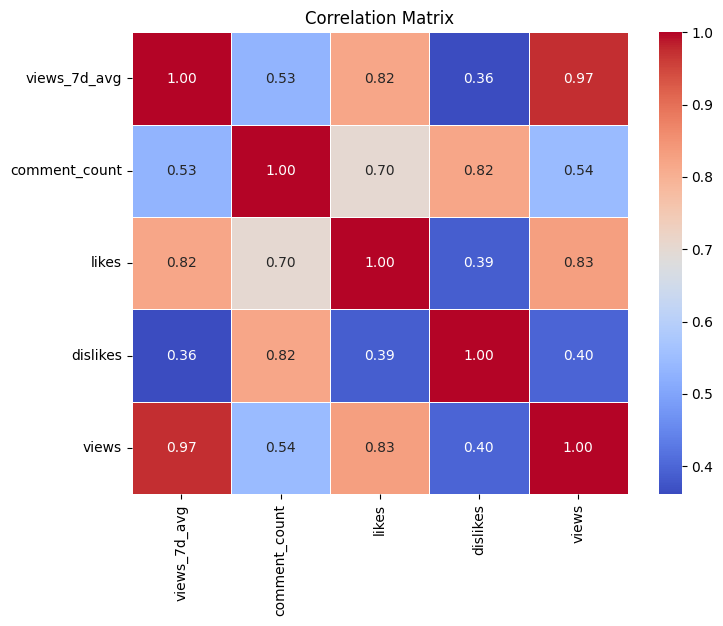

Correlation between views_7d_avg and views: 0.974
Correlation between comment_count and views: 0.544
Correlation between likes and views: 0.833
Correlation between dislikes and views: 0.398


In [8]:
# CORRELATION CALCULATION
# Numeric columns for correlation calculation
numeric_features = ['views_7d_avg','comment_count', 'likes', 'dislikes', 'views']

# Calculate correlation matrix for selected numeric features
correlation_scores = df[numeric_features].corr()

# CORRELATION VISUALIZATION
# Display the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_scores, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Print the individual correlations with views
for feature in numeric_features:
    if feature != 'views':  # Don't calculate correlation for the target itself
        correlation_score = df[feature].corr(df['views'])
        print(f"Correlation between {feature} and views: {correlation_score:.3f}")

##### 7-day moving average of views (views_7d_avg): This variable shows a very strong positive relationship with views, indicating that past performance is a key predictor for future views. Videos that have been performing well recently are likely to continue attracting more views.
##### Comments (comment_count): There is a moderate positive correlation with views, suggesting that as videos gain more views, they also tend to receive more comments. However, other factors could also influence the number of comments, indicating that comments are somewhat tied to views, but not as strongly as other engagement metrics like likes.
##### Likes: A strong positive relationship with views indicates that higher engagement (through likes) is strongly linked to a video’s success. Videos with more likes tend to have more views, signaling that popular videos are generally more liked by viewers.
##### Dislikes: While there is a weaker positive correlation with views, dislikes have a lesser impact on predicting views compared to likes and comments. Dislikes may indicate polarizing content, but they don't appear to be a major factor in driving the view count.
##### Publish hour (publish_hour): The correlation with views is very weak, suggesting that the time of day when a video is published has little to no impact on its total views. Other factors, such as content quality or engagement, are likely more important than the timing of publication.

In [10]:
# UNTUNED LINEAR REGRESSION

# Create and fit Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions with the Linear Regression model
lr_pred = lr_model.predict(X_test_scaled)

# Evaluate the Linear Regression model
lr_mse = mean_squared_error(y_test, lr_pred)  # Mean Squared Error (MSE)
lr_r2 = r2_score(y_test, lr_pred)  # R-squared score
lr_mae = mean_absolute_error(y_test, lr_pred)  # Mean Absolute Error (MAE)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred)) # Root MSE

# MODEL WITH FEATURE COEFFICIENTS
# Create and fit the model using scaled data
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)

# PERFORMANCE
print("Untuned Linear Regression MSE:", lr_mse)
print("Untuned Linear Regression R²:", lr_r2)
print("Untuned Linear Regression MAE:", lr_mae)
print("Untuned Linear Regression RMSE:", lr_rmse)

Untuned Linear Regression MSE: 1189363537715.991
Untuned Linear Regression R²: 0.9705600001468402
Untuned Linear Regression MAE: 388605.4024115466
Untuned Linear Regression RMSE: 1090579.4504372394


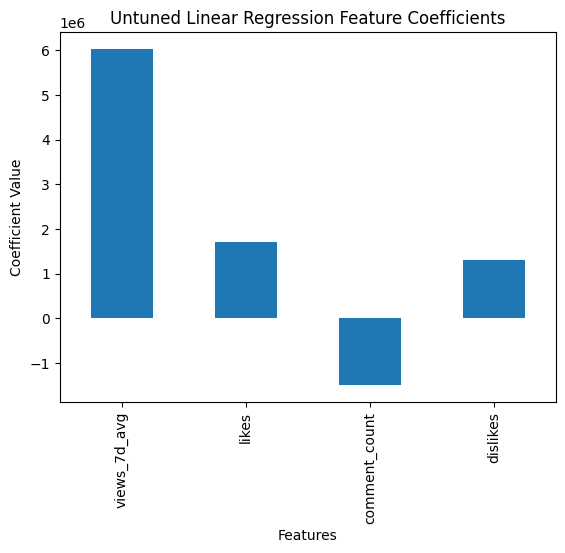

In [11]:
# UNTUNED LINEAR REGRESSION FEATURE COEFFICIENT PLOT

# Display feature importance (coefficients)
coefficients = pd.DataFrame(model_lr.coef_, X_train.columns, columns=['Coefficient'])
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()  
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)

# Linear Regression Coefficients Plot
coefficients['Coefficient'].plot(kind='bar')
plt.title('Untuned Linear Regression Feature Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

##### 7-Day Average Views: The views_7day_avg feature has the highest coefficient, significantly outpacing others, indicating it is the strongest predictor of total views. This metric captures recent engagement, showing that videos consistently attracting views over the past week are highly likely to continue trending.
##### Likes: Although less impactful than the 7-day average, likes are still a substantial factor in view count prediction, with a positive but smaller coefficient. High like counts are a strong indication of popularity and positive reception, both of which contribute meaningfully to overall views.
##### Dislikes: Dislikes show a smaller positive correlation with view count. This suggests that polarizing content, which gains more dislikes, may still drive viewer curiosity and engagement.
##### Comment Count: Comments also contribute to view predictions but to a lesser degree. Engagement through comments signals active interaction but does not influence view count as strongly as likes, dislikes, or recent view trends.

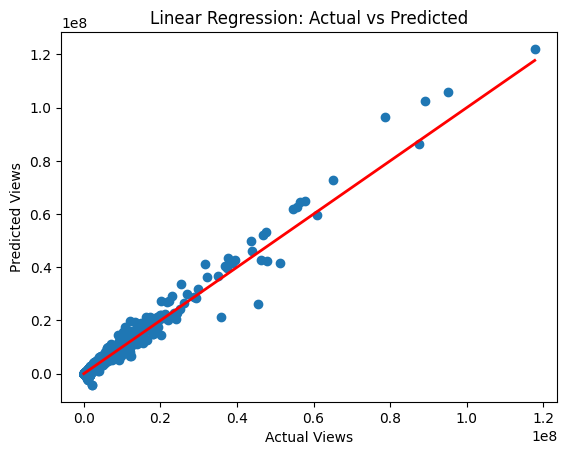

In [18]:
# UNTUNED PREDICTED VS. ACTUAL FOR LINEAR REGRESSION

# Predicted vs Actual for Linear Regression
plt.scatter(y_test, lr_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.title('Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.show()

In [22]:
# LINEAR REGRESSION TUNING - RIDGE REGRESSION 

# Set up the parameter grid for Ridge regression (regularized Linear Regression)
param_grid_lr = {
    'alpha': [0.1, 1, 10, 100]  # Regularization strength
}

# Perform GridSearchCV for Linear Regression (Ridge)
grid_search_lr = GridSearchCV(Ridge(), param_grid_lr, cv=5, scoring='neg_mean_squared_error')
grid_search_lr.fit(X_train_scaled, y_train)

# PERFORMANCE
# Get the best parameters
print("Best parameters for Linear Regression:", grid_search_lr.best_params_)

# Evaluate the best Ridge model
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test_scaled)

# Recalculate MSE and R² for the tuned model
lr_mse_tuned = mean_squared_error(y_test, y_pred_lr)
lr_r2_tuned = r2_score(y_test, y_pred_lr)
lr_mae_tuned = mean_absolute_error(y_test, y_pred_lr)  
lr_rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_lr)) 
print("Tuned Linear Regression MSE:", lr_mse_tuned)
print("Tuned Linear Regression R²:", lr_r2_tuned)
print("Tuned Linear Regression MAE:", lr_mae_tuned)
print("Tuned Linear Regression RMSE:", lr_rmse_tuned)

Best parameters for Linear Regression: {'alpha': 10}
Tuned Linear Regression MSE: 1184753019314.363
Tuned Linear Regression R²: 0.9706741230846659
Tuned Linear Regression MAE: 387476.79974766815
Tuned Linear Regression RMSE: 1088463.6049562534


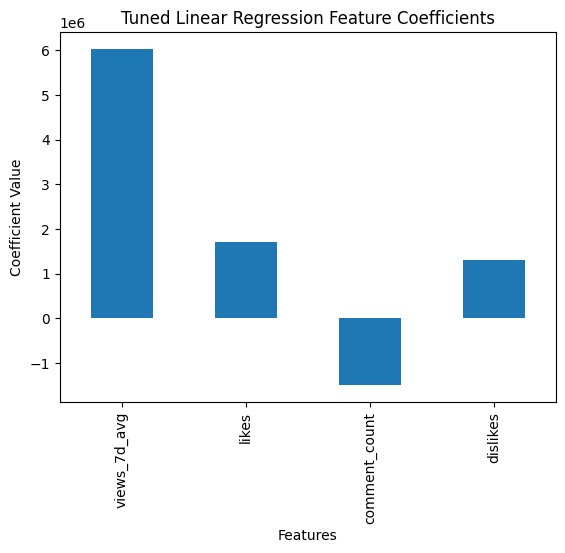

In [25]:
# TUNED LINEAR REGRESSION FEATURE COEFFICIENT PLOT

# Get Feature Coefficients from Tuned Model
coefficients_tuned = pd.DataFrame(best_lr_model.coef_, X_train.columns, columns=['Coefficient'])
coefficients_tuned['Abs_Coefficient'] = coefficients_tuned['Coefficient'].abs()
coefficients_tuned = coefficients_tuned.sort_values(by='Abs_Coefficient', ascending=False)

# Plot Coefficients 
coefficients['Coefficient'].plot(kind='bar')
plt.title('Tuned Linear Regression Feature Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()

##### The tuned coefficients largely mirror the untuned results in terms of feature importance and relationships. The 7-day average views remain the dominant predictor, followed by likes, dislikes, and comments, with minimal changes in their relative impact.

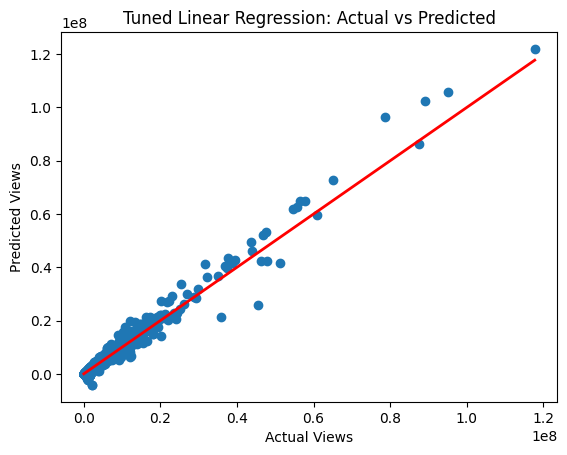

In [28]:
# TUNED PREDICTED VS. ACTUAL FOR LINEAR REGRESSION

# Recalculate predictions for tuned model
lr_pred_tuned = best_lr_model.predict(X_test_scaled)

# Reprint Predicted vs Actual for tuned Linear Regression
plt.scatter(y_test, lr_pred_tuned)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.title('Tuned Linear Regression: Actual vs Predicted')
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.show()

In [30]:
untuned_lr = {
    'MSE': lr_mse,
    'R²': lr_r2,
    'MAE': lr_mae,
    'RMSE': lr_rmse
}
pd.DataFrame([untuned_lr]).to_csv('untunedlr_results.csv', index=False)


tuned_lr = {
    'MSE': lr_mse_tuned,
    'R²': lr_r2_tuned,
    'MAE': lr_mae_tuned,
    'RMSE': lr_rmse_tuned
}
pd.DataFrame([tuned_lr]).to_csv('lr_results.csv', index=False)
